<a href="https://colab.research.google.com/github/antbartash/australian_rain/blob/main/BayesianOptimization_skopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install scikit-optimize
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate
from skopt import BayesSearchCV
from skopt.space import *
from skopt.learning import ExtraTreesRegressor
from skopt.plots import plot_convergence

In [3]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/antbartash/australian_rain/main/data/data_transformed.csv',
    index_col=0
  )

print(data.shape)
data.head()

(142193, 23)


,Location,WindGustDir,WindDir9am,WindDir3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2.0,13.0,13.0,14.0,13.4,22.9,0.6,NaN,NaN,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,12.0
1,2.0,14.0,6.0,15.0,7.4,25.1,0.0,NaN,NaN,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,12.0
2,2.0,15.0,13.0,15.0,12.9,25.7,0.0,NaN,NaN,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,12.0
3,2.0,4.0,9.0,0.0,9.2,28.0,0.0,NaN,NaN,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,12.0
4,2.0,13.0,1.0,7.0,17.5,32.3,1.0,NaN,NaN,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,12.0


In [4]:
X, y = data.drop(columns=['RainTomorrow', 'RainToday']), data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [5]:
def get_catboost_dataset(data):
    for column in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
        data[column] = data[column].astype(np.float32).fillna(-1).apply(lambda x: str(x))
    return data

X_train, X_test = get_catboost_dataset(X_train), get_catboost_dataset(X_test)

X_train.dtypes

Location          object
WindGustDir       object
WindDir9am        object
WindDir3pm        object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustSpeed    float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
Month            float64
dtype: object

# Baseline model

In [ ]:
baseline_model = CatBoostClassifier(
    n_estimators=100,
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=False, task_type='GPU'
)
cv_result = cross_validate(baseline_model, X_train, y_train, scoring='roc_auc',
                           return_train_score=True)

print(f"Mean train Gini: {cv_result['train_score'].mean() * 2 - 1}")
print(f"Mean test Gini: {cv_result['test_score'].mean() * 2 - 1}")
print(f"Mean fit time: {np.round(cv_result['fit_time'].mean(), 2)} s")

Mean train Gini: 0.7969690629654458
Mean test Gini: 0.774699918460324
Mean fit time: 2.15 s


# Bayesian Optimization Gaussian Process (BOGP)

In [ ]:
hyperparameter_space = {
    'n_estimators': Integer(low=100, high=500),
    'learning_rate': Real(low=1e-6, high=0.5, prior='log-uniform'),
    'depth': Integer(1, 8),
    'l2_leaf_reg': Real(0.0, 100.0),
    # 'random_strength': uniform(loc=0.01, scale=50), # CPU only
    'bagging_temperature': Real(0.0, 100.0),
    'grow_policy': Categorical(['SymmetricTree', 'Depthwise']),
    'scale_pos_weight': Integer(low=1, high=4)
}

model = CatBoostClassifier(
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=False, task_type='GPU'
)

clf = BayesSearchCV(
    model, hyperparameter_space, n_iter=50,
    optimizer_kwargs={
        'base_estimator': 'GP', # 'RF', 'ET', 'GBRT'
        'n_initial_points': 5,
        'initial_point_generator': 'random', # 'grid'
        'acq_func': 'gp_hedge', # probabilistically choose one of ['EI', 'LCB', 'PI'] acquisition functions at every iteration
        'acq_func_kwargs': {'xi': 0.1},
        'n_jobs': -1, # default: 1
        'random_state': 42
    },
    scoring='roc_auc', cv=3,
    random_state=42, n_jobs=-1, verbose=3
)

clf.fit(X_train, y_train) # 40 min

In [ ]:
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Best Gini: 0.7877009336342455
Best params: OrderedDict([('bagging_temperature', 0.0), ('depth', 7), ('grow_policy', 'SymmetricTree'), ('l2_leaf_reg', 100.0), ('learning_rate', 0.49999999999999994), ('n_estimators', 500), ('scale_pos_weight', 1)])


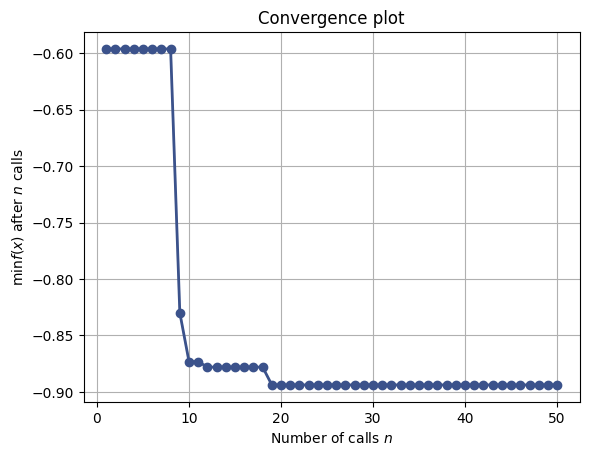

In [ ]:
plot_convergence(clf.optimizer_results_)
plt.show()

# Bayesian Optimization with GBRT

## xi=0.01 (default)

In [ ]:
hyperparameter_space = {
    'n_estimators': Integer(low=100, high=500),
    'learning_rate': Real(low=1e-6, high=0.5, prior='log-uniform'),
    'depth': Integer(1, 8),
    'l2_leaf_reg': Real(0.0, 100.0),
    # 'random_strength': uniform(loc=0.01, scale=50), # CPU only
    'bagging_temperature': Real(0.0, 100.0),
    'grow_policy': Categorical(['SymmetricTree', 'Depthwise']),
    'scale_pos_weight': Integer(low=1, high=4)
}

model = CatBoostClassifier(
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=False, task_type='GPU'
)

clf = BayesSearchCV(
    model, hyperparameter_space, n_iter=50,
    optimizer_kwargs={
        'base_estimator': 'GBRT', # 'RF', 'ET', 'GBRT'
        'n_initial_points': 5,
        'initial_point_generator': 'random', # 'grid'
        'acq_func': 'gp_hedge', # probabilistically choose one of ['EI', 'LCB', 'PI'] acquisition functions at every iteration
        'acq_func_kwargs': {'xi': 0.01},
        'n_jobs': -1, # default: 1
        'random_state': 42
    },
    scoring='roc_auc', cv=3,
    random_state=42, n_jobs=-1, verbose=3
)

clf.fit(X_train, y_train) # 40 min

In [ ]:
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Best Gini: 0.7815301301718047
Best params: OrderedDict([('bagging_temperature', 3.382901552513196), ('depth', 5), ('grow_policy', 'SymmetricTree'), ('l2_leaf_reg', 29.020861609261033), ('learning_rate', 0.38848151497632455), ('n_estimators', 285), ('scale_pos_weight', 3)])


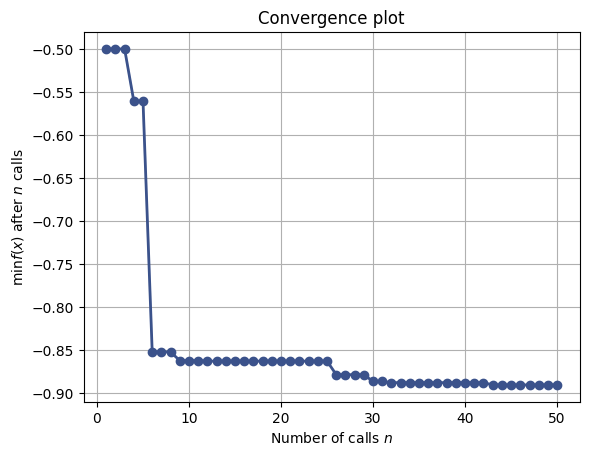

In [ ]:
plot_convergence(clf.optimizer_results_)
plt.show()

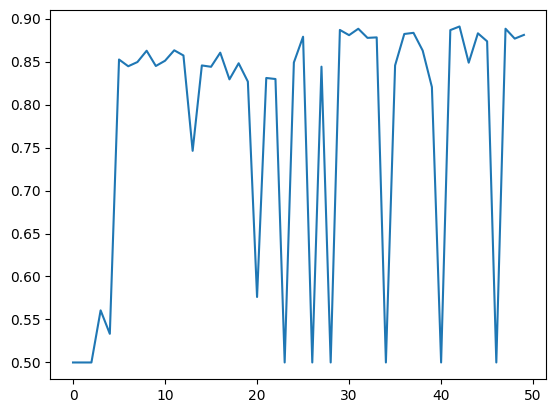

In [ ]:
plt.plot(clf.cv_results_['mean_test_score'])

## xi=0.3

In [ ]:
hyperparameter_space = {
    'n_estimators': Integer(low=100, high=500),
    'learning_rate': Real(low=1e-6, high=0.5, prior='log-uniform'),
    'depth': Integer(1, 8),
    'l2_leaf_reg': Real(0.0, 100.0),
    # 'random_strength': uniform(loc=0.01, scale=50), # CPU only
    'bagging_temperature': Real(0.0, 100.0),
    'grow_policy': Categorical(['SymmetricTree', 'Depthwise']),
    'scale_pos_weight': Integer(low=1, high=4)
}

model = CatBoostClassifier(
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=False, task_type='GPU'
)

clf = BayesSearchCV(
    model, hyperparameter_space, n_iter=50,
    optimizer_kwargs={
        'base_estimator': 'GBRT', # 'RF', 'ET', 'GBRT'
        'n_initial_points': 5,
        'initial_point_generator': 'random', # 'grid'
        'acq_func': 'gp_hedge', # probabilistically choose one of ['EI', 'LCB', 'PI'] acquisition functions at every iteration
        'acq_func_kwargs': {'xi': 0.3},
        'n_jobs': -1, # default: 1
        'random_state': 42
    },
    scoring='roc_auc', cv=3,
    random_state=42, n_jobs=-1, verbose=3
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=<catboost.core.CatBoostClassifier object at 0x78b06152cc40>,
              n_jobs=-1,
              optimizer_kwargs={'acq_func': 'gp_hedge',
                                'acq_func_kwargs': {'xi': 0.3},
                                'base_estimator': 'GBRT',
                                'initial_point_generator': 'random',
                                'n_initial_points': 5, 'n_jobs': -1,
                                'random_state': 42},
              random_state=42, scoring='roc_auc',
              search_spaces={'bagging_temperature': Rea...
                             'grow_policy': Categorical(categories=('SymmetricTree', 'Depthwise'), prior=None),
                             'l2_leaf_reg': Real(low=0.0, high=100.0, prior='uniform', transform='identity'),
                             'learning_rate': Real(low=1e-06, high=0.5, prior='log-uniform', transform='identity'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='identity'),
                             'scale_pos_weight': Integer(low=1, high=4, prior='uniform', transform='identity')},
              verbose=3)

In [ ]:
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Best Gini: 0.7892953636237265
Best params: OrderedDict([('bagging_temperature', 2.397859046872675), ('depth', 6), ('grow_policy', 'SymmetricTree'), ('l2_leaf_reg', 77.78560135652512), ('learning_rate', 0.3191215210247547), ('n_estimators', 427), ('scale_pos_weight', 1)])


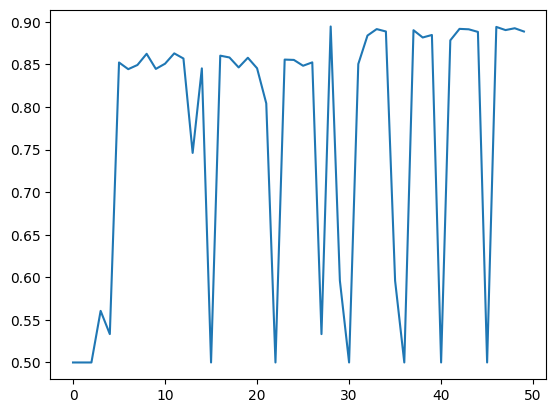

In [ ]:
plt.plot(clf.cv_results_['mean_test_score'])

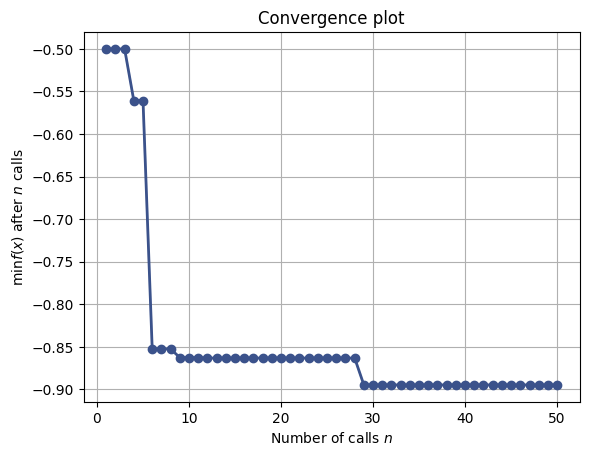

In [ ]:
plot_convergence(clf.optimizer_results_)
plt.show()

## xi=0.5

In [ ]:
hyperparameter_space = {
    'n_estimators': Integer(low=100, high=500),
    'learning_rate': Real(low=1e-6, high=0.5, prior='log-uniform'),
    'depth': Integer(1, 8),
    'l2_leaf_reg': Real(0.0, 100.0),
    # 'random_strength': uniform(loc=0.01, scale=50), # CPU only
    'bagging_temperature': Real(0.0, 100.0),
    'grow_policy': Categorical(['SymmetricTree', 'Depthwise']),
    'scale_pos_weight': Integer(low=1, high=4)
}

model = CatBoostClassifier(
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=False, task_type='GPU'
)

clf = BayesSearchCV(
    model, hyperparameter_space, n_iter=50,
    optimizer_kwargs={
        'base_estimator': 'GBRT', # 'RF', 'ET', 'GBRT'
        'n_initial_points': 5,
        'initial_point_generator': 'random', # 'grid'
        'acq_func': 'gp_hedge', # probabilistically choose one of ['EI', 'LCB', 'PI'] acquisition functions at every iteration
        'acq_func_kwargs': {'xi': 0.5},
        'n_jobs': -1, # default: 1
        'random_state': 42
    },
    scoring='roc_auc', cv=3,
    random_state=42, n_jobs=-1, verbose=3
)

clf.fit(X_train, y_train)

In [ ]:
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Best Gini: 0.7905678795625397
Best params: OrderedDict([('bagging_temperature', 2.563443725345183), ('depth', 7), ('grow_policy', 'SymmetricTree'), ('l2_leaf_reg', 84.26603034551529), ('learning_rate', 0.09452712706295154), ('n_estimators', 392), ('scale_pos_weight', 4)])


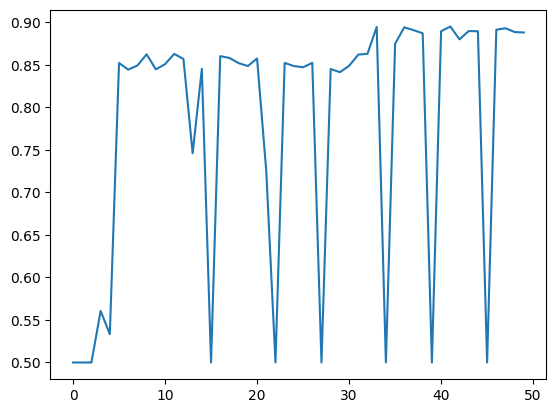

In [ ]:
plt.plot(clf.cv_results_['mean_test_score'])

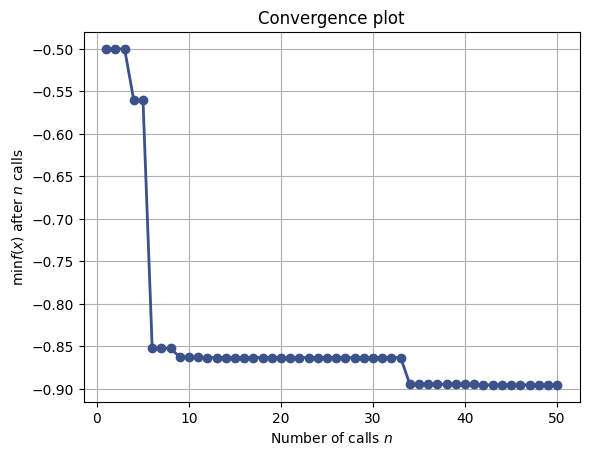

In [ ]:
plot_convergence(clf.optimizer_results_)
plt.show()

## xi=0.0001

In [ ]:
hyperparameter_space = {
    'n_estimators': Integer(low=100, high=500),
    'learning_rate': Real(low=1e-6, high=0.5, prior='log-uniform'),
    'depth': Integer(1, 8),
    'l2_leaf_reg': Real(0.0, 100.0),
    # 'random_strength': uniform(loc=0.01, scale=50), # CPU only
    'bagging_temperature': Real(0.0, 100.0),
    'grow_policy': Categorical(['SymmetricTree', 'Depthwise']),
    'scale_pos_weight': Integer(low=1, high=4)
}

model = CatBoostClassifier(
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=False, task_type='GPU'
)

clf = BayesSearchCV(
    model, hyperparameter_space, n_iter=50,
    optimizer_kwargs={
        'base_estimator': 'GBRT', # 'RF', 'ET', 'GBRT'
        'n_initial_points': 5,
        'initial_point_generator': 'random', # 'grid'
        'acq_func': 'gp_hedge', # probabilistically choose one of ['EI', 'LCB', 'PI'] acquisition functions at every iteration
        'acq_func_kwargs': {'xi': 0.0001},
        'n_jobs': -1, # default: 1
        'random_state': 42
    },
    scoring='roc_auc', cv=3,
    random_state=42, n_jobs=-1, verbose=3
)

clf.fit(X_train, y_train)

In [10]:
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Best Gini: 0.745016282981565
Best params: OrderedDict([('bagging_temperature', 30.6242005256734), ('depth', 4), ('grow_policy', 'SymmetricTree'), ('l2_leaf_reg', 87.91954476831413), ('learning_rate', 0.11372650358668895), ('n_estimators', 362), ('scale_pos_weight', 4)])


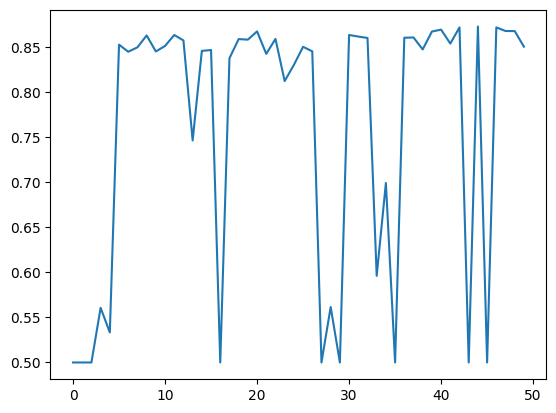

In [11]:
plt.plot(clf.cv_results_['mean_test_score'])

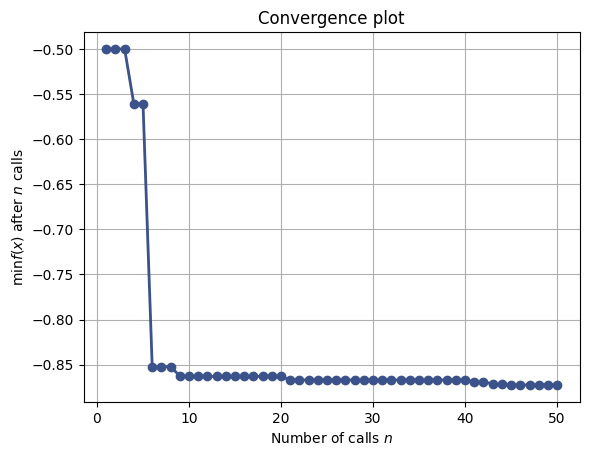

In [12]:
plot_convergence(clf.optimizer_results_)
plt.show()